In [293]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import av
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split

In [298]:
trainPath = './all_labels.csv'


train_df = pd.read_csv(trainPath)

In [299]:
train_df.shape

(295, 8)

In [300]:
# drop duplicates for single testing

train_df = train_df.drop_duplicates(subset = "filename", keep = False)


train_df.head(20)





,filename,width,height,class,xmin,ymin,xmax,ymax
0,20.jpg,534,401,pothole,9,258,534,397
1,193.jpg,1297,859,pothole,288,384,935,598
2,164.jpg,1632,1224,pothole,559,550,1386,882
3,142.jpg,700,525,pothole,104,162,411,461
4,192.jpg,1200,600,pothole,62,287,962,473
9,57.jpg,900,600,pothole,302,219,580,355
10,129.jpg,873,1281,pothole,268,594,666,840
11,161.jpg,1080,675,pothole,352,390,812,632
12,80.jpg,759,422,pothole,3,202,759,421
13,154.jpg,640,268,pothole,115,150,541,199


In [301]:
# scale each image to 128 by 128 for simplicity

newSize = (128,128)

train_df.xmin = train_df.xmin.astype(float)
train_df.xmax = train_df.xmax.astype(float)
train_df.ymin = train_df.ymin.astype(float)
train_df.ymax = train_df.ymax.astype(float)


train_df = train_df.reset_index()
train_df = train_df.drop(columns='index')

for index, row in train_df.iterrows():
    
    origSize = (row['width'],row['height'])
    if (origSize[0]==0 or origSize[1]==0):
        
        train_df = train_df.drop(index=index)
        
    else:
        
        
        xRatio, yRatio = float(1)/float(origSize[0]),float(1)/float(origSize[1])
                
        train_df.at[index, 'xmin'] = float(row.xmin)*float(xRatio)
        train_df.at[index, 'xmax'] = float(row.xmax)*float(xRatio)
        
        train_df.at[index, 'ymin'] = float(row.ymin)*float(yRatio)
        train_df.at[index, 'ymax'] = float(row.ymax)*float(yRatio)
        
        
train_df = train_df.reset_index()
train_df = train_df.drop(columns='index')
train_df.head(20)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20.jpg,534,401,pothole,0.016854,0.643392,1.000000,0.990025
1,193.jpg,1297,859,pothole,0.222051,0.447031,0.720894,0.696158
2,164.jpg,1632,1224,pothole,0.342525,0.449346,0.849265,0.720588
3,142.jpg,700,525,pothole,0.148571,0.308571,0.587143,0.878095
4,192.jpg,1200,600,pothole,0.051667,0.478333,0.801667,0.788333
5,57.jpg,900,600,pothole,0.335556,0.365000,0.644444,0.591667
6,129.jpg,873,1281,pothole,0.306987,0.463700,0.762887,0.655738
7,161.jpg,1080,675,pothole,0.325926,0.577778,0.751852,0.936296
8,80.jpg,759,422,pothole,0.003953,0.478673,1.000000,0.997630
9,154.jpg,640,268,pothole,0.179688,0.559701,0.845313,0.742537


In [302]:
train_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,20.jpg,534,401,pothole,0.016854,0.643392,1.000000,0.990025
1,193.jpg,1297,859,pothole,0.222051,0.447031,0.720894,0.696158
2,164.jpg,1632,1224,pothole,0.342525,0.449346,0.849265,0.720588
3,142.jpg,700,525,pothole,0.148571,0.308571,0.587143,0.878095
4,192.jpg,1200,600,pothole,0.051667,0.478333,0.801667,0.788333


In [303]:

frames = []
for index, row in train_df.iterrows():
    pic = Image.open('all/'+row.filename).convert('RGB')
    frames.append(np.asarray(pic.resize(newSize)))

# frames = []
# for frame in container.decode(video=0):
#     frames.append(np.asarray(frame.to_image().resize(newSize))/255.0)

In [304]:
frames = np.array(frames)
frames.shape

(70, 128, 128, 3)

In [305]:
labels = train_df.drop(columns=['filename','width','height','class']).to_numpy()
train_df.drop(columns=['filename','width','height','class']).head()


,xmin,ymin,xmax,ymax
0,0.016854,0.643392,1.000000,0.990025
1,0.222051,0.447031,0.720894,0.696158
2,0.342525,0.449346,0.849265,0.720588
3,0.148571,0.308571,0.587143,0.878095
4,0.051667,0.478333,0.801667,0.788333


In [313]:
X_train, X_test, Y_train, Y_test = train_test_split(frames, labels, test_size=0.20, random_state=42)

In [314]:
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256, (2,2), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [315]:
model.compile(optimizer= 'adam', loss='mean_squared_error')

In [316]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=20)

Train on 56 samples, validate on 14 samples
Epoch 1/20
56/56 [==============================] - 2s 40ms/sample - loss: 126.9743 - val_loss: 2.9759
Epoch 2/20
56/56 [==============================] - 1s 21ms/sample - loss: 1.9757 - val_loss: 0.1100
Epoch 3/20
56/56 [==============================] - 1s 20ms/sample - loss: 0.1572 - val_loss: 0.1951
Epoch 4/20
56/56 [==============================] - 1s 22ms/sample - loss: 0.2301 - val_loss: 0.0636
Epoch 5/20
56/56 [==============================] - 1s 22ms/sample - loss: 0.1168 - val_loss: 0.1055
Epoch 6/20
56/56 [==============================] - 1s 22ms/sample - loss: 0.0842 - val_loss: 0.1039
Epoch 7/20
56/56 [==============================] - 1s 20ms/sample - loss: 0.0955 - val_loss: 0.0587
Epoch 8/20
56/56 [==============================] - 1s 20ms/sample - loss: 0.0467 - val_loss: 0.1058
Epoch 9/20
56/56 [==============================] - 1s 20ms/sample - loss: 0.0722 - val_loss: 0.0629
Epoch 10/20
56/56 [==========================

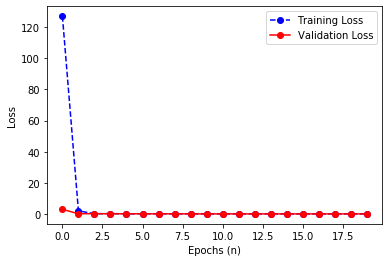

In [317]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

(56, 128, 128, 3)
(9.703225806451613, 30.15980339050293)
(33.02211302211302, 55.9631462097168)
(112.30967741935484, 101.55144338300151)
(83.65601965601965, 70.61691743442995)


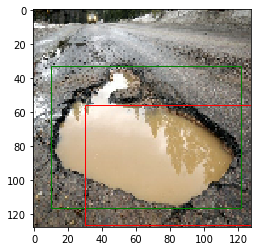

In [318]:
print(X_train.shape)

imgNum = 0
plt.imshow(X_train[imgNum])
ax = plt.gca()
[x,y,w,h] = Y_train[imgNum]
[[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_train[imgNum], axis=0))

x = x*newSize[0]
y = y*newSize[1]
w = w*newSize[0]-x
h = h*newSize[1]-y

x1= x1*newSize[0]
y1= y1*newSize[1]
w1= w1*newSize[0]-x
h1= h1*newSize[1]-y

rect = pat.Rectangle((x,y),w,h, linewidth = 1, edgecolor='g', facecolor='none')
ax.add_patch(rect)
rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))

(18.133333333333333, 10.215899467468262)
(110.72, 51.13233947753906)
(35.2, 62.96320056915283)
(16.0, 85.04088932275772)


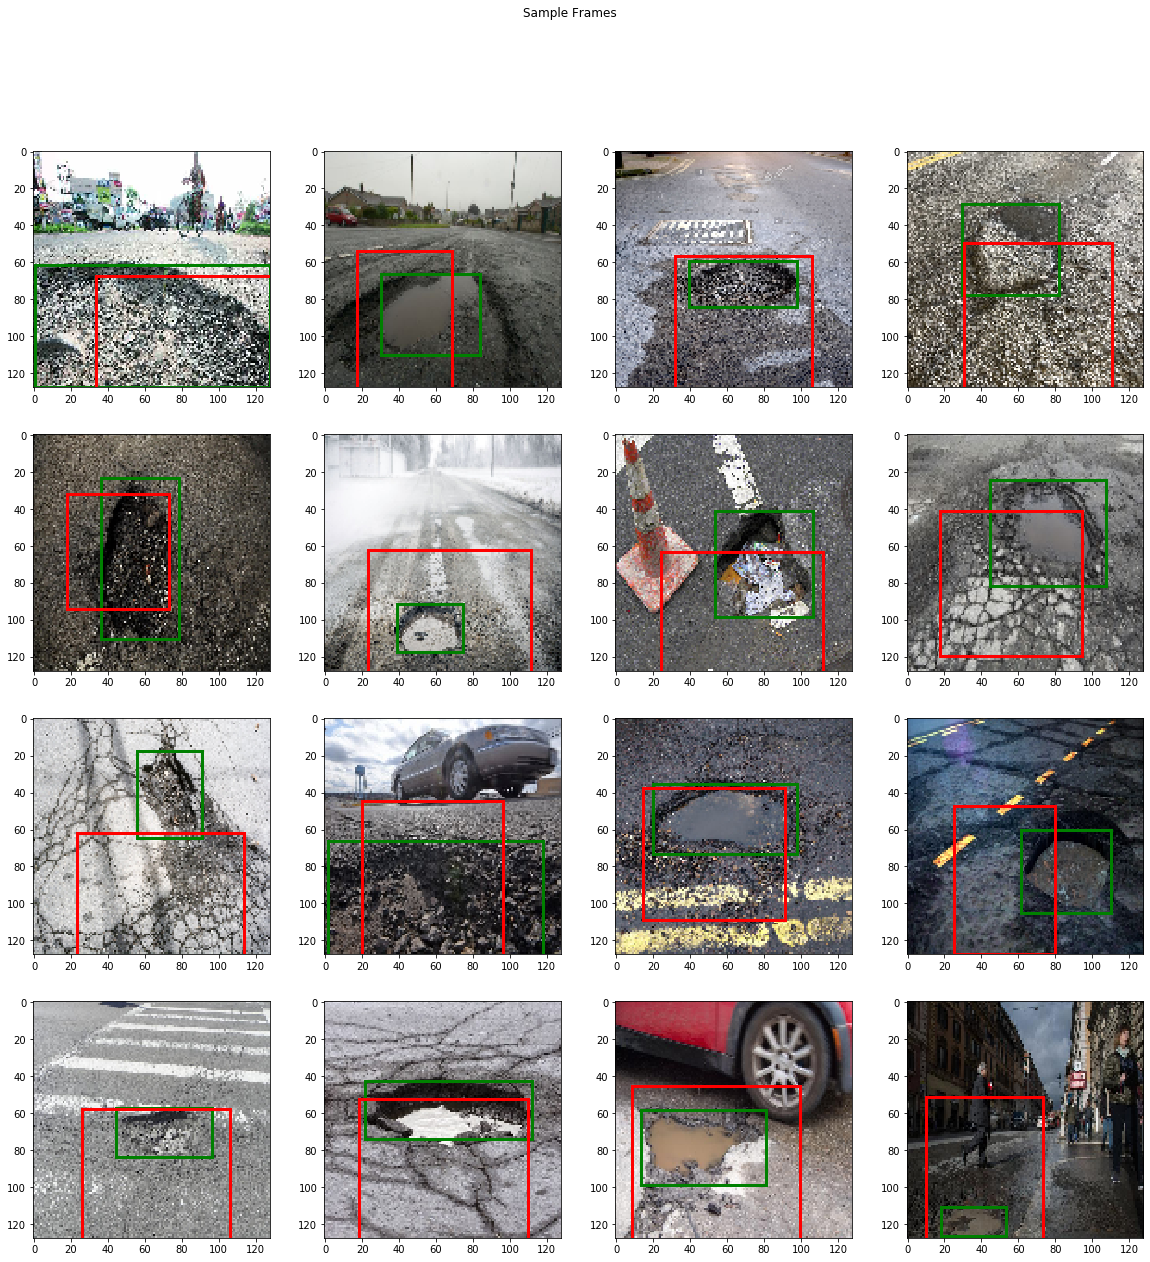

In [319]:
shift = 4
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_train[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_train[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_train[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_train[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]-x
    h = h*newSize[1]-y

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]-x1
    h1= h1*newSize[1]-h1

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))